In [1]:
import os
import numpy as np
import umap
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import tree
import graphviz
import pm4py
import hdbscan
from sklearn import metrics
from PetriNet2Vec import PetriNet2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
pm4py.util.constants.SHOW_PROGRESS_BAR = False
import warnings
warnings.filterwarnings('ignore')

# Set the seed for reproducibility
random_seed = 42
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

2024-02-28 17:44:26.825177: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 17:44:26.869837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 17:44:26.869871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 17:44:26.870861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 17:44:26.878002: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 17:44:26.879052: I tensorflow/core/platform/cpu_feature_guard.cc:1

Basic model

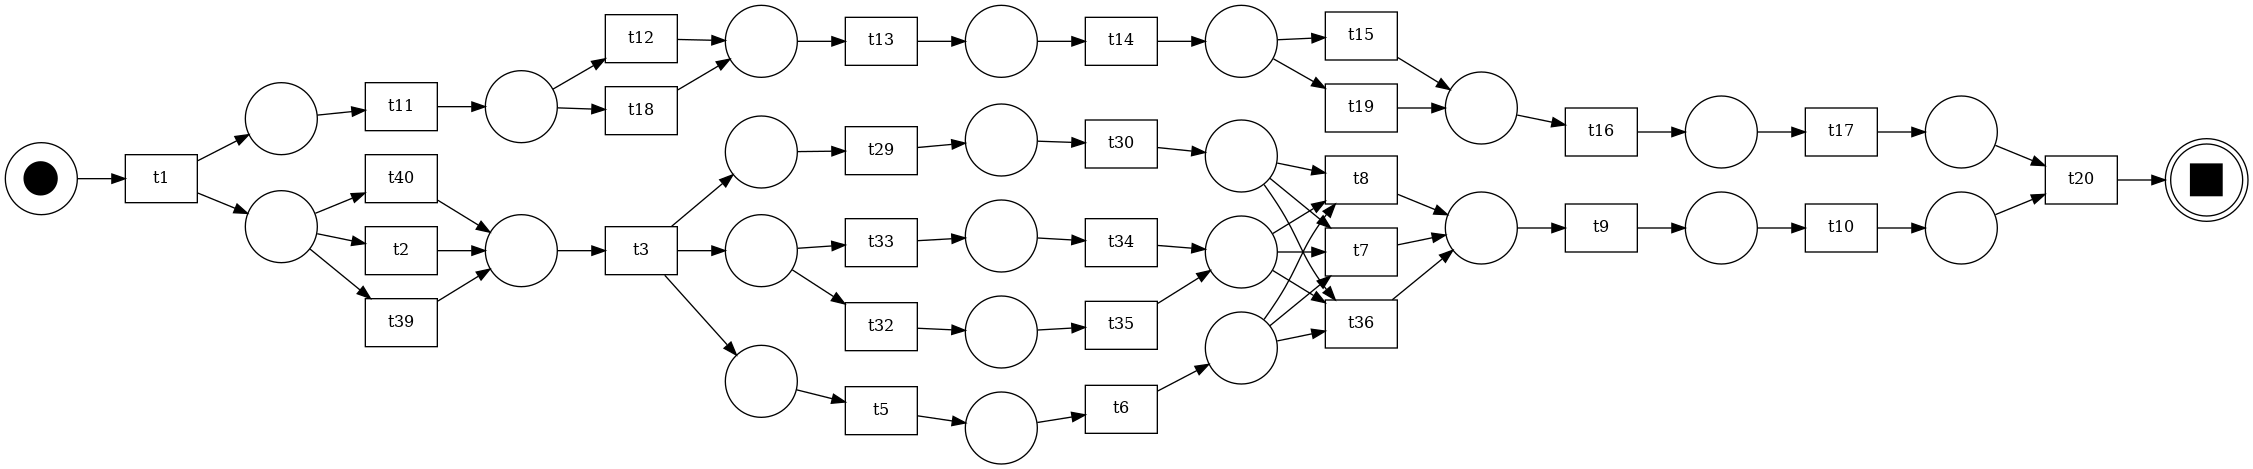

In [2]:
net, im, fm = pm4py.read_pnml('../Dataset/Models/pdc2023_000000.pnml')
pm4py.view_petri_net(net, im, fm)

Auxiliar functions

In [3]:
def reverse_dict(original_dict):
    reversed_dict = {}
    for key, value in original_dict.items():
        reversed_dict[value] = key
    return reversed_dict

def build_tree_rules(models, labels, n_clusters):
    X = np.zeros((len(models),6))
    y = np.zeros((len(models)))

    k = 0
    for cluster in range(n_clusters):
        for i in np.where(labels==cluster)[0]:
            # converting names files to features and clusters to labels
            input_string = models[i].split('.')[0].split('_')[1]
            for j, char in enumerate(input_string):
                X[k, j] = char
            y[k] = cluster
            k += 1

    clf = tree.DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X, y)
    text_representation = tree.export_text(clf)
    print(text_representation)

def plot_shilhouette(embeddings_vectors, labels, file_name):

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embeddings_vectors, labels)
    silhouette_avg = metrics.silhouette_score(embeddings_vectors, labels)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Number of clusters in labels, ignoring noise if present.

    fig, ax1 = plt.subplots(figsize=(5,4))
    colors = len(sample_silhouette_values)*[0]
    y_lower = 0
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        for pos in np.where(labels == i)[0]:
            colors[int(pos)] = color
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.25 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper

    for pos, color in enumerate(colors):
        if color == 0:
            colors[pos] = (1.,1.,1.,1.)

    ax1.set_xlim([-0.06,np.max(ith_cluster_silhouette_values)+0.2])
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label='silhouette_avg')
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    plt.legend(loc='upper right')
    plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/'+file_name+'.png')
    plt.show()

    return colors

Loading Petri Nets models (dataset)

In [4]:
models = sorted(os.listdir('../Dataset/Models/'))
petriNets = []
petriNets_im = []
petriNets_fm = []
for model in models:
    net, im, fm = pm4py.read_pnml(os.path.join('../Dataset/Models/', model))
    petriNets.append(net)
    petriNets_im.append(im)
    petriNets_fm.append(fm)

Instantiate model and train it

In [5]:
# PNML Embedding Parameters
model = PetriNet2Vec(embedding_dim=8, # '8' minimum acceptable number of embedding dimensions
                     seed=random_seed, 
                     black_transitions=True, # Use the token 'None' to represent black boxes
                     workers=8)

# Optional line: Uncomment to initialize weights from a checkpoint, ensuring consistent results across multiple script executions.
model.load_model_from("initial_model_weights") 
model.fit(petriNets, epochs=1000)
model.save_model("trained_model")

Tasks histogram

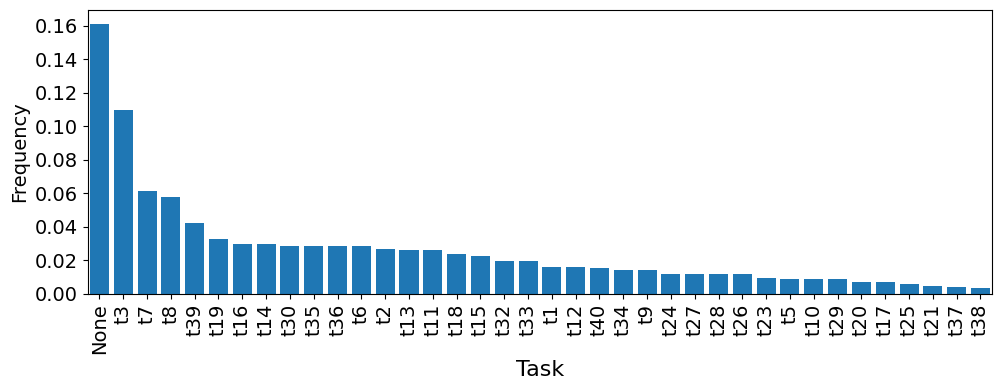

In [6]:
word_count = {key:0 for key, value in model._task_keys.items()}

for doc in model._documents:
    for word in doc.words:
        word_count[word] += 1

# Extract keys and values
x_ticks = list(word_count.keys())
frequencies = list(word_count.values())
frequencies = frequencies/np.sum(frequencies)

# Create the histogram
plt.figure(figsize=(10, 4))
plt.bar(x_ticks, frequencies)
plt.xlabel("Task", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.tight_layout()
plt.xlim([-0.5,37.5])
plt.xticks()
plt.yticks(fontsize=14)
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/histogram_methodology_1.png')
plt.show()

HDBSCAN

In [7]:
embeddings_vectors = normalize(model.get_net_embeddings().copy())
cluster = hdbscan.HDBSCAN(min_cluster_size=4) # Hierarchical DBSCAN with cosine similarity
labels = cluster.fit_predict(embeddings_vectors)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Number of clusters in labels, ignoring noise if present.
n_noise = list(labels).count(-1)
Silhouette = metrics.silhouette_score(embeddings_vectors, labels)
davies_score = metrics.davies_bouldin_score(embeddings_vectors, labels)

print(f"Silhouette Coefficient: {Silhouette:.3f}", 
        'n_clusters:', n_clusters,
        'n_noise:', n_noise,
        f"davies_score: {davies_score:.3f}")

Silhouette Coefficient: 0.718 n_clusters: 8 n_noise: 0 davies_score: 0.415


Plot Silhouette

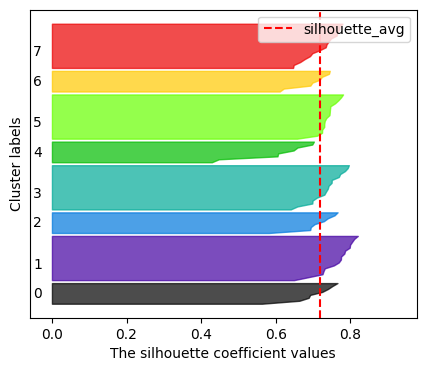

In [8]:
colors = plot_shilhouette(embeddings_vectors, labels, file_name = 'silhouette_models')

UMAP Net projections

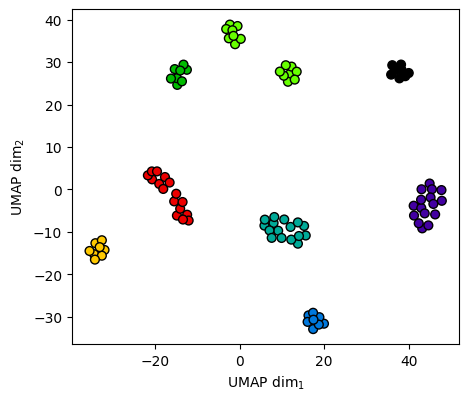

In [9]:
embeddings_vectors = normalize(model.get_net_embeddings().copy())
reducer = umap.UMAP(metric='cosine', spread=10.0, random_state=random_seed)
embedding = reducer.fit_transform(embeddings_vectors)

plt.figure(figsize=(5, 4.35))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=40, edgecolors='black')
plt.xlabel(r'UMAP dim$_1$')
plt.ylabel(r'UMAP dim$_2$')
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/UMAP_models.png')
plt.show()

View the memebers of some cluster

In [10]:
clusters_members = {}
cluster_sizes = []

for cluster in range(n_clusters):
    print("\nCluster: ", cluster)
    clusters_members[str(cluster)] = []
    n = 0
    for i in np.where(labels==cluster)[0]:
        n += 1
        clusters_members[str(cluster)].append(models[i])
        print(i, models[i])
    cluster_sizes.append(n)


Cluster:  0
0 pdc2023_000000.pnml
2 pdc2023_000010.pnml
8 pdc2023_001000.pnml
10 pdc2023_001010.pnml
48 pdc2023_100000.pnml
50 pdc2023_100010.pnml
56 pdc2023_101000.pnml
58 pdc2023_101010.pnml

Cluster:  1
16 pdc2023_010000.pnml
18 pdc2023_010010.pnml
24 pdc2023_011000.pnml
26 pdc2023_011010.pnml
32 pdc2023_020000.pnml
34 pdc2023_020010.pnml
40 pdc2023_021000.pnml
42 pdc2023_021010.pnml
64 pdc2023_110000.pnml
66 pdc2023_110010.pnml
72 pdc2023_111000.pnml
74 pdc2023_111010.pnml
80 pdc2023_120000.pnml
82 pdc2023_120010.pnml
88 pdc2023_121000.pnml
90 pdc2023_121010.pnml

Cluster:  2
1 pdc2023_000001.pnml
3 pdc2023_000011.pnml
9 pdc2023_001001.pnml
11 pdc2023_001011.pnml
49 pdc2023_100001.pnml
51 pdc2023_100011.pnml
57 pdc2023_101001.pnml
59 pdc2023_101011.pnml

Cluster:  3
17 pdc2023_010001.pnml
19 pdc2023_010011.pnml
25 pdc2023_011001.pnml
27 pdc2023_011011.pnml
33 pdc2023_020001.pnml
35 pdc2023_020011.pnml
41 pdc2023_021001.pnml
43 pdc2023_021011.pnml
65 pdc2023_110001.pnml
67 pdc2023_

Learned Rules

In [11]:
build_tree_rules(models, labels, n_clusters)

|--- feature_5 <= 0.50
|   |--- feature_3 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 1.0
|   |--- feature_3 >  0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 4.0
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 5.0
|--- feature_5 >  0.50
|   |--- feature_3 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 2.0
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 3.0
|   |--- feature_3 >  0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 6.0
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 7.0



pdc2023_000000.pnml


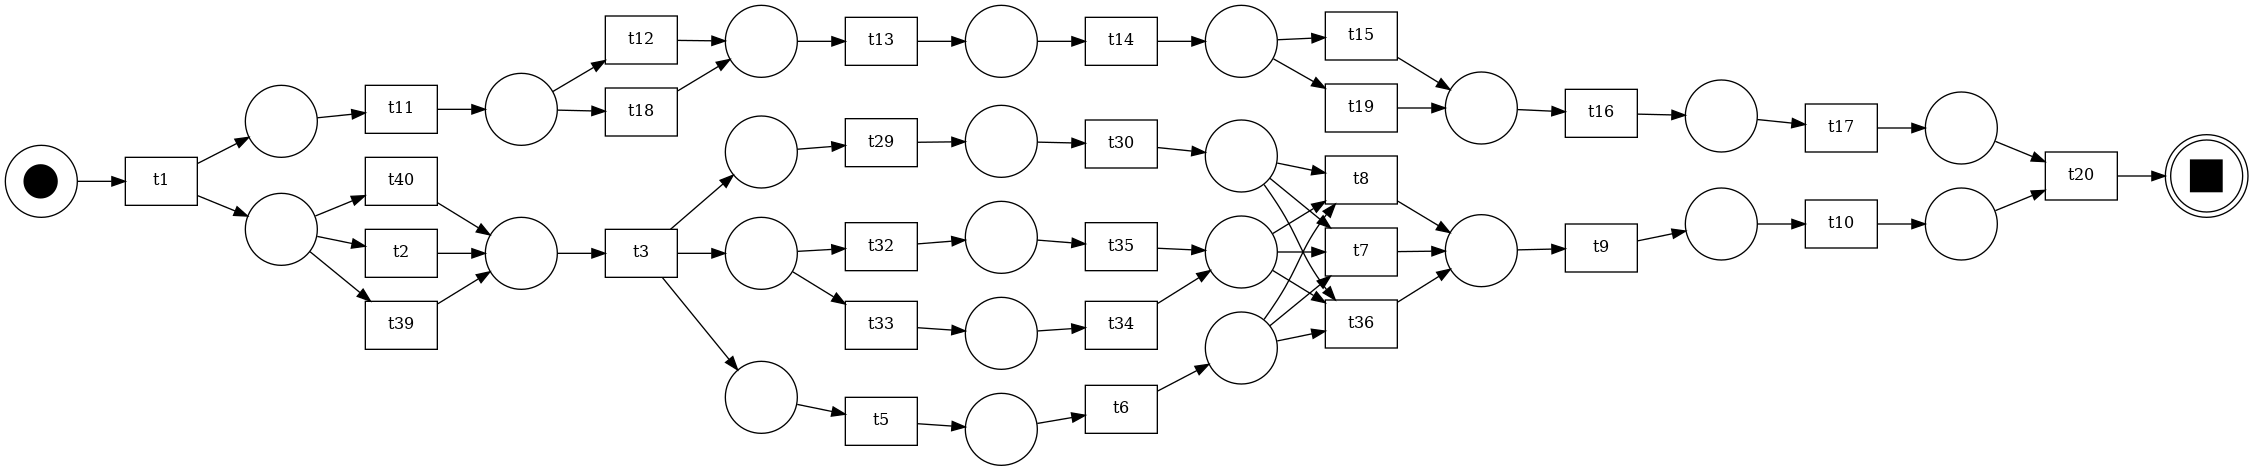

pdc2023_000010.pnml


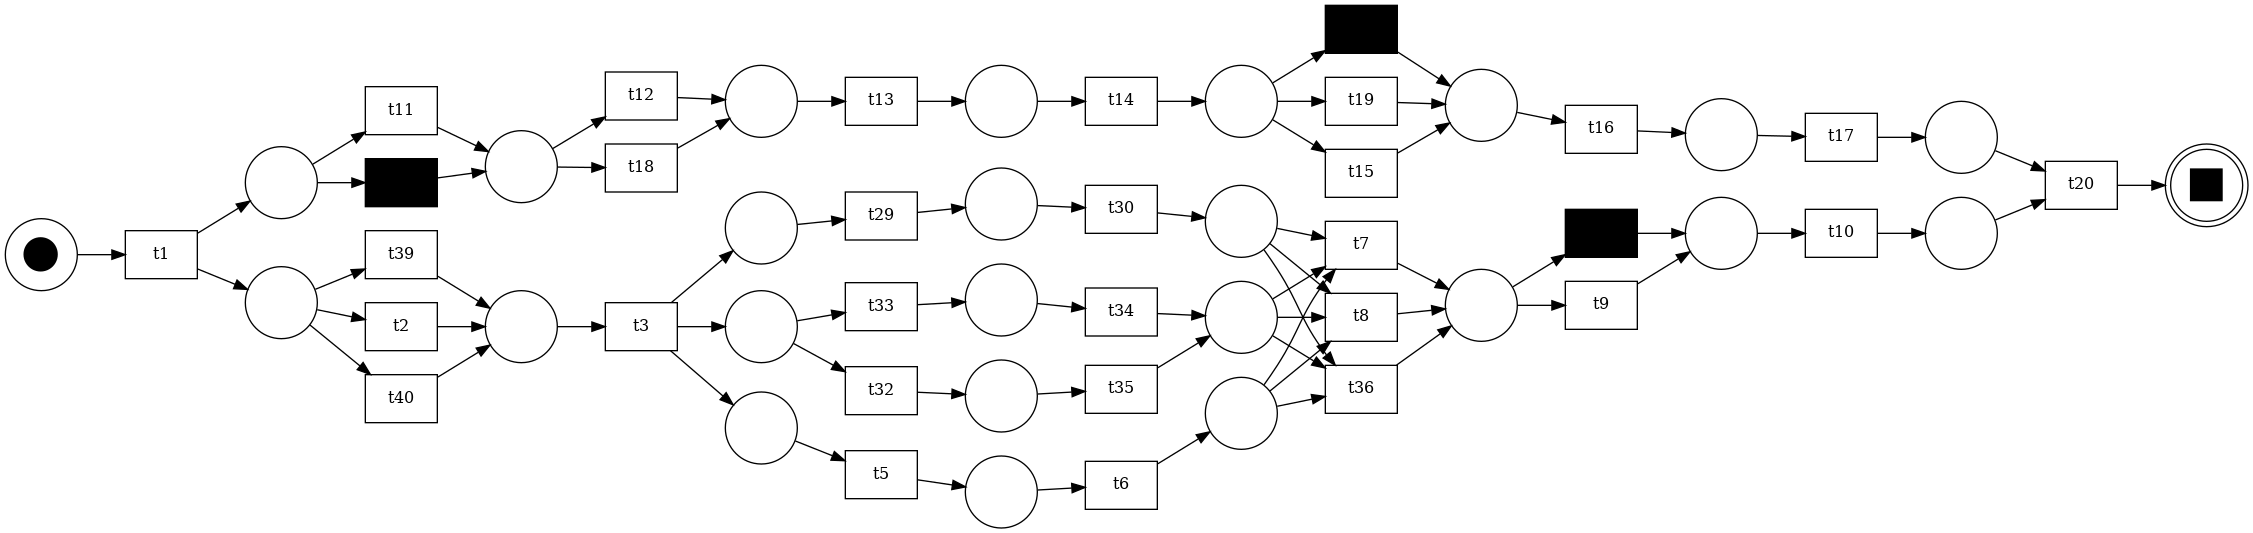

pdc2023_001000.pnml


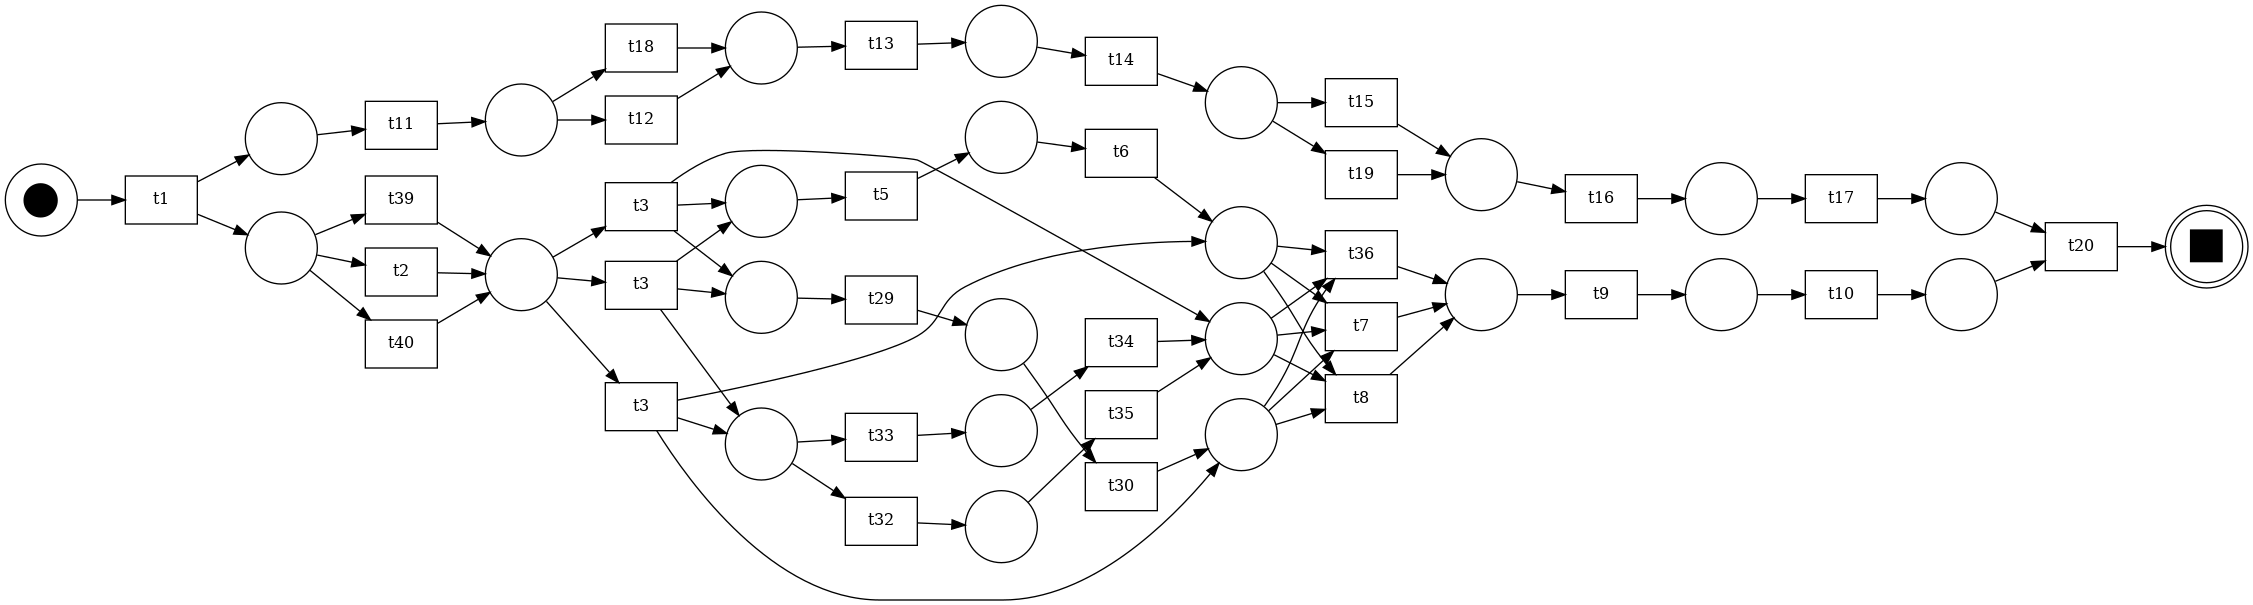

pdc2023_001010.pnml


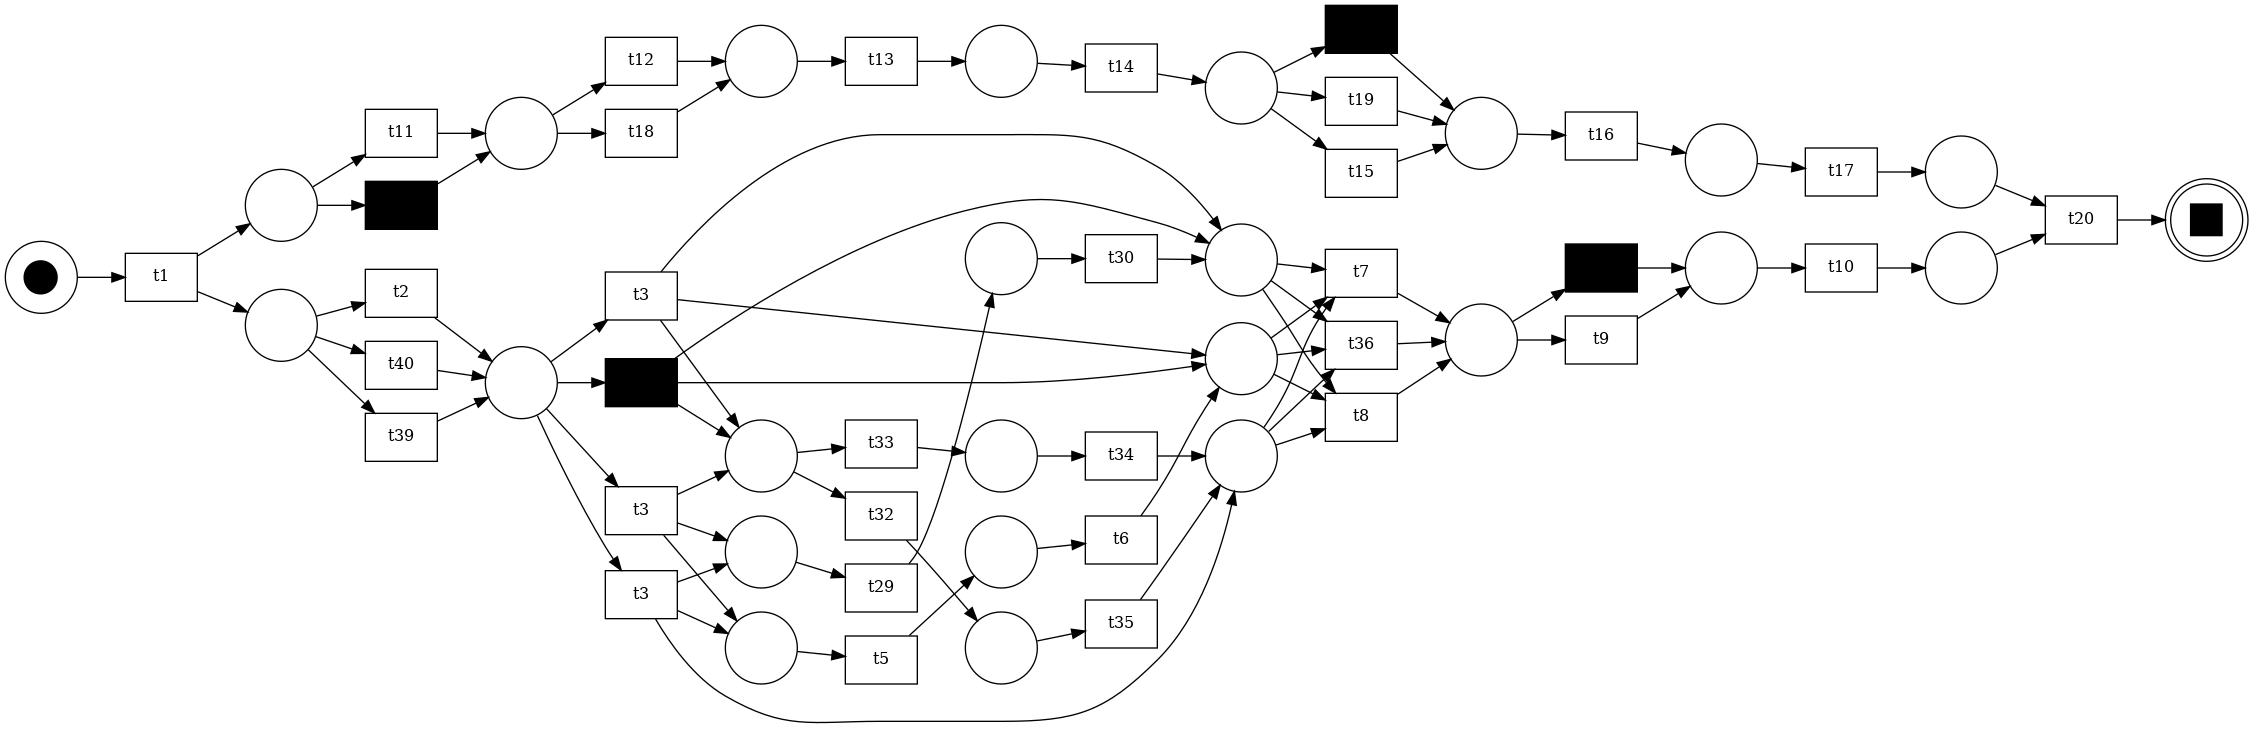

In [12]:
# showing the fisrt four cluster members
for i, member in enumerate(clusters_members['0']):
    if i < 4:
        print(member)
        net, im, fm = pm4py.read_pnml(os.path.join('../Dataset/Models/', member))
        pm4py.view_petri_net(net, im, fm)

Solving similar query model

pdc2023_010100.pnml


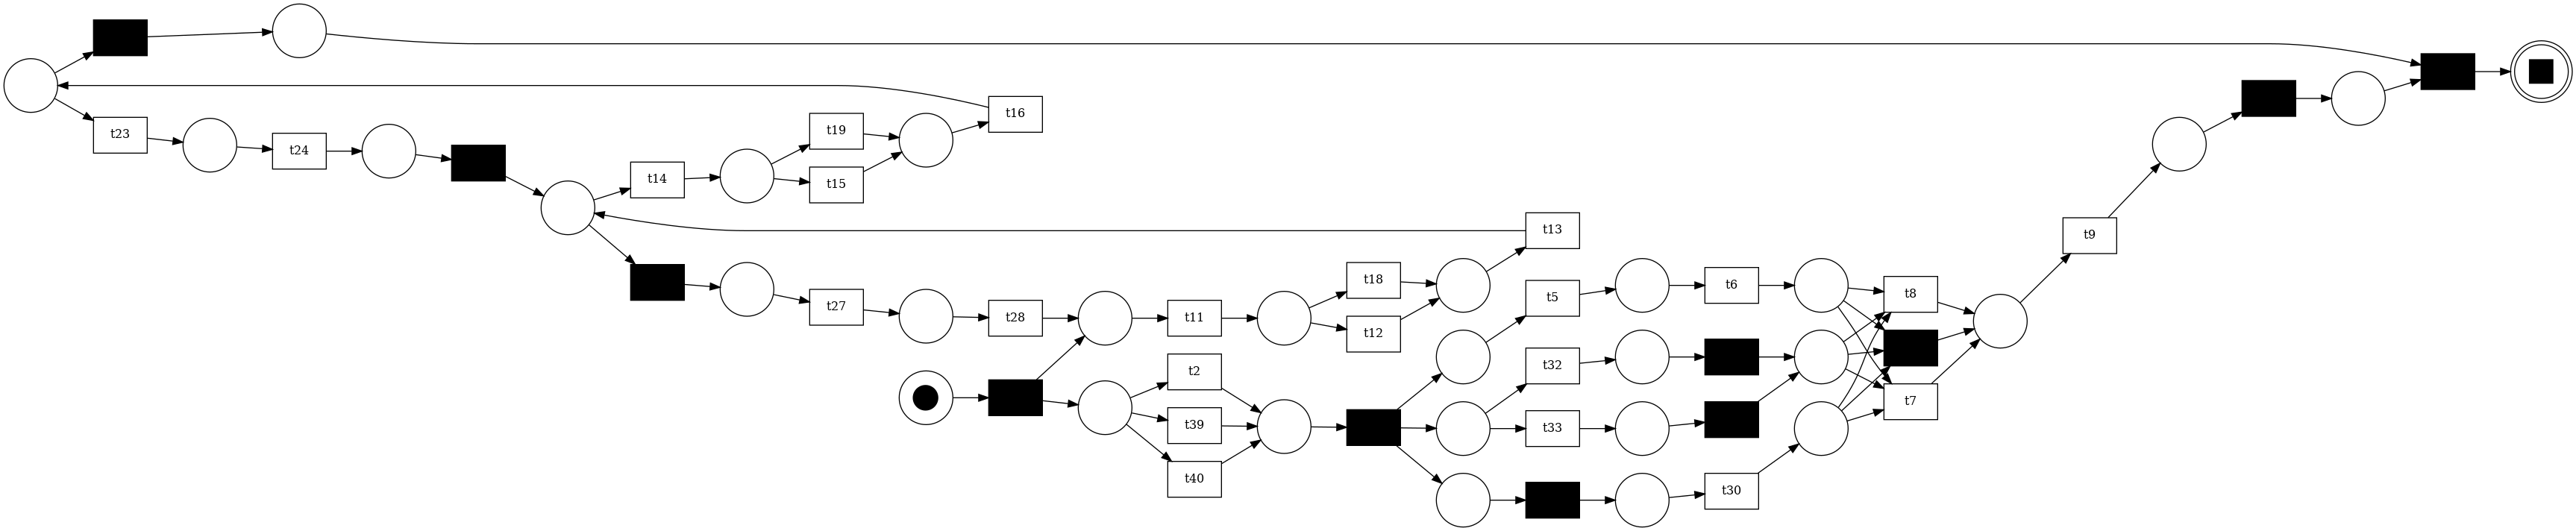

22 pdc2023_010110.pnml


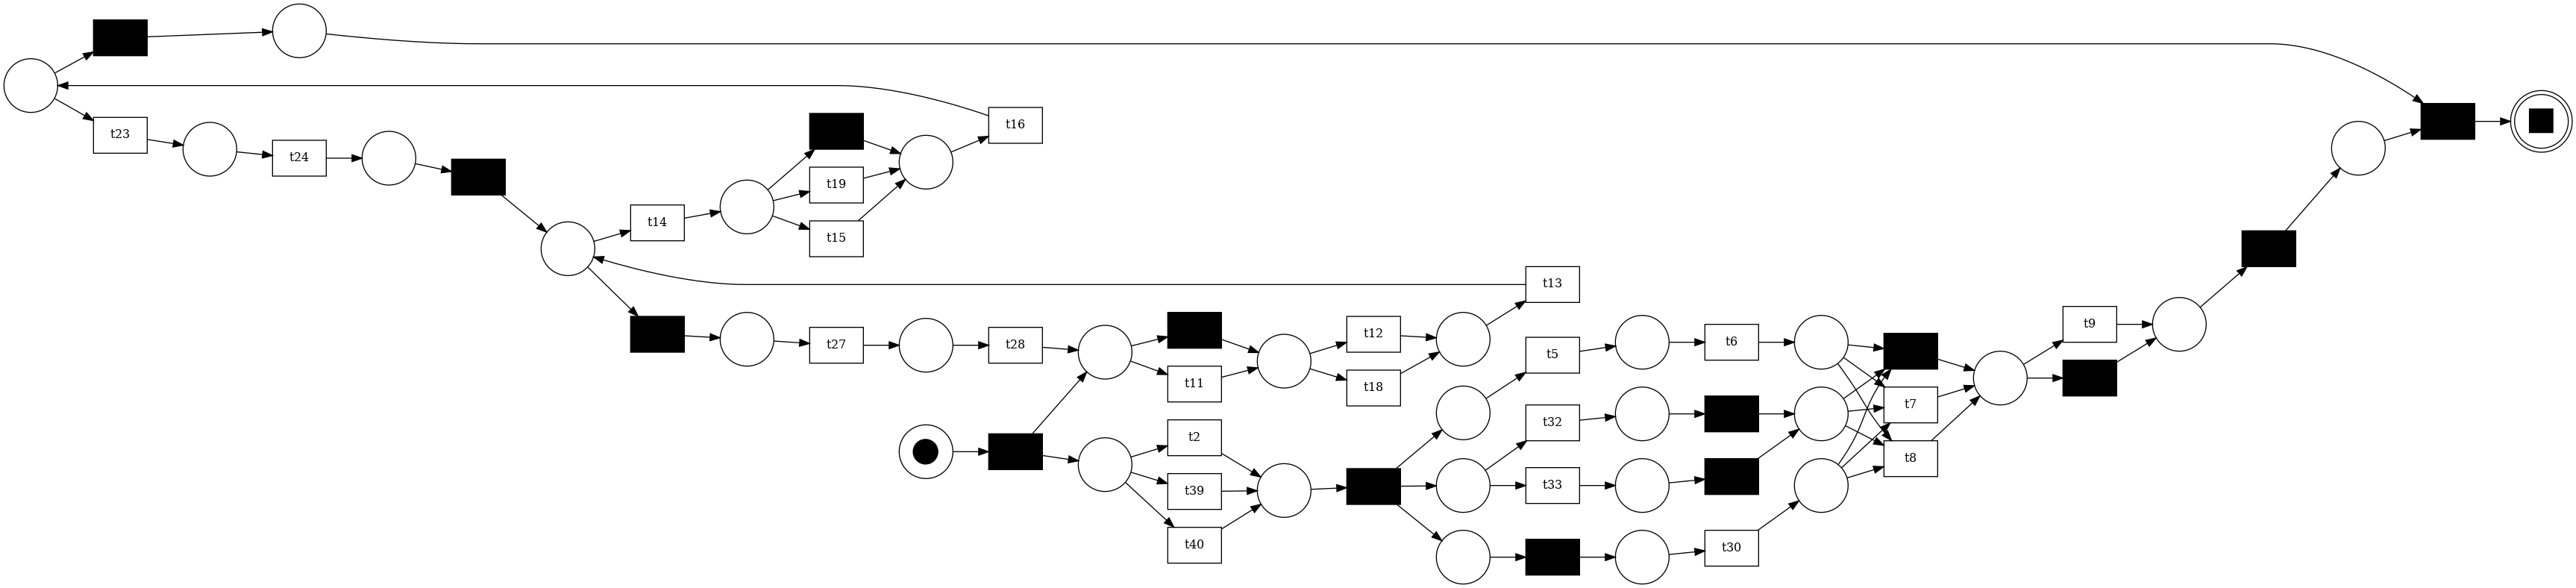

In [13]:
j = '20'
net_id = model._net_keys[j]

print(models[net_id])
pm4py.view_petri_net(petriNets[net_id], petriNets_im[net_id], petriNets_fm[net_id])


models_embeddings = normalize(model.get_net_embeddings().copy())
sim_matrix = [model.similarity(embedding, models_embeddings[net_id]) for embedding in models_embeddings]
nearest_neighbor = np.argsort(sim_matrix)[::-1][2]

print(nearest_neighbor, models[nearest_neighbor])
pm4py.view_petri_net(petriNets[nearest_neighbor], petriNets_im[nearest_neighbor], petriNets_fm[nearest_neighbor])

Similarity matrix between model embeddings

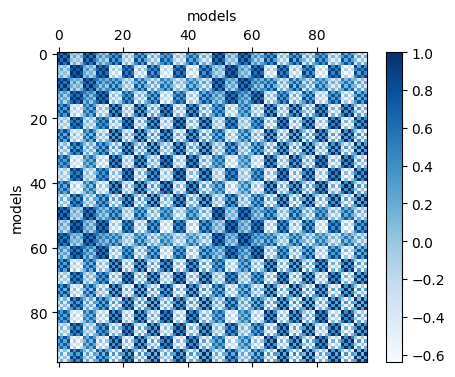

In [14]:
models_embeddings = normalize(model.get_net_embeddings().copy())
matrix_models = similarity_matrix = cosine_similarity(models_embeddings)

# Create the heatmap
plt.figure(figsize=(5,4))
plt.matshow(matrix_models, cmap="Blues", fignum=1)  # Adjust cmap for different color schemes
plt.colorbar()
plt.clim(np.min(matrix_models), 1)
plt.title('models', fontsize=10)
plt.ylabel('models')
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/models_similarity_matrix.png')
plt.show()

Cluster of task embeddings - HDBSCAN

In [15]:
embeddings_vectors = normalize(model.get_task_embeddings().copy())
cluster = hdbscan.HDBSCAN(min_cluster_size=2) # Hierarchical DBSCAN with cosine similarity
labels_task = cluster.fit_predict(embeddings_vectors)
n_clusters_tasks = len(set(labels_task)) - (1 if -1 in labels_task else 0) # Number of clusters in labels, ignoring noise if present.
n_noise = list(labels_task).count(-1)
Silhouette = metrics.silhouette_score(embeddings_vectors, labels_task)
davies_score = metrics.davies_bouldin_score(embeddings_vectors, labels_task)

print(f"Silhouette Coefficient: {Silhouette:.3f}", 
        'n_clusters:', n_clusters_tasks,
        'n_noise:', n_noise,
        f"davies_score: {davies_score:.3f}")

Silhouette Coefficient: 0.174 n_clusters: 6 n_noise: 11 davies_score: 1.584


Silhouette Plot

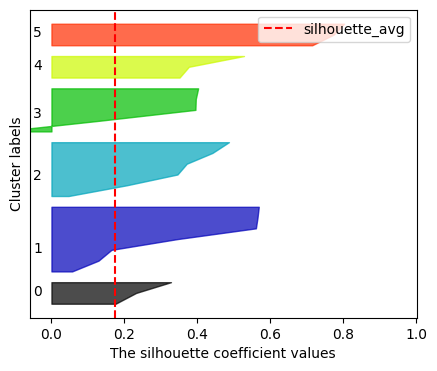

In [16]:
colors = plot_shilhouette(embeddings_vectors, labels_task, file_name = 'silhouette_task')

UMAP task embeddings

In [17]:
embeddings_vectors = normalize(model.get_task_embeddings().copy())
reducer = umap.UMAP(metric='cosine', spread=5, random_state=random_seed)
embedding = reducer.fit_transform(embeddings_vectors)

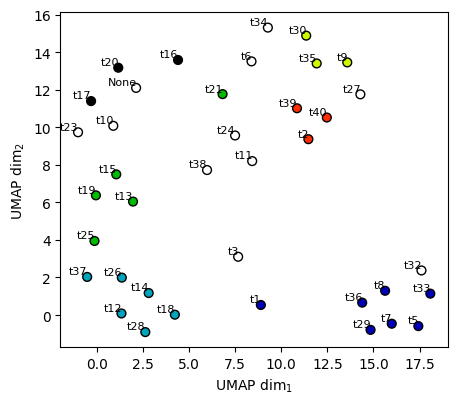

In [18]:
for pos, color in enumerate(colors):
    if color == 0:
        colors[pos] = (1.,1.,1.,1.)

plt.figure(figsize=(5, 4.35))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=40, edgecolors='black')
for key, value in model._task_keys.items():
    plt.text(embedding[value,0]+0.03, embedding[value,1]+0.03, key, fontsize=8, ha='right', va='bottom')

#plt.colorbar()
plt.xlabel(r'UMAP dim$_1$')
plt.ylabel(r'UMAP dim$_2$')
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/UMAP_task.png')
plt.show()

Query an specific task

In [19]:
query = 't40'
task_embeddings = normalize(model.get_task_embeddings().copy())
task1 = model.get_task_embeddings(query).copy()
sim_matrix = [model.similarity(task1, embedding) for embedding in task_embeddings]
nearest_neighbor = np.argsort(sim_matrix)[::-1][2]
keys_task = reverse_dict(model._task_keys)
print('query:', query, 'result:', keys_task[int(nearest_neighbor)])

query: t40 result: t2


Similarity matrix between tasks

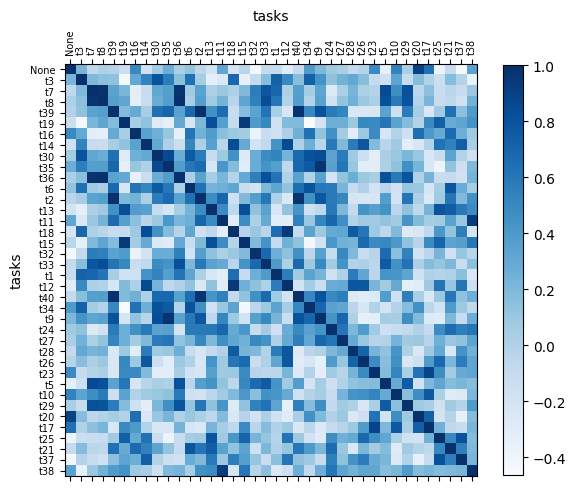

In [20]:
task_embeddings = normalize(model.get_task_embeddings().copy())
matrix_tasks = similarity_matrix = cosine_similarity(task_embeddings)

task_keys = []
for key, value in model._task_keys.items():
    task_keys.append(key)

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(matrix_tasks, cmap="Blues")
ax.set_yticks(range(len(task_keys)))
ax.set_xticks(range(len(task_keys)))
ax.set_yticklabels(task_keys, fontsize=7)
ax.set_xticklabels(task_keys, rotation=90, fontsize=7)
cbar = fig.colorbar(cax, shrink=0.73)  # Colorbar associated with the matrix
cbar.set_label('',fontsize=7)

plt.title('tasks', fontsize=10)
plt.ylabel('tasks')
plt.tight_layout()
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/task_similarity_matrix.png')
plt.show()

Similarity matrix between models and tasks

In [21]:
models_embeddings = normalize(model.get_net_embeddings().copy())
X = []
models_names = []
cluster_labels = []
for cluster in range(n_clusters):
    for i in np.where(labels==cluster)[0]:
        X.append(models_embeddings[i,:])
        models_names.append(models[i].split('_')[1].split('.')[0])
        cluster_labels.append(str(cluster))
X = np.array(X)
matrix_models_tasks = similarity_matrix = cosine_similarity(task_embeddings, X)

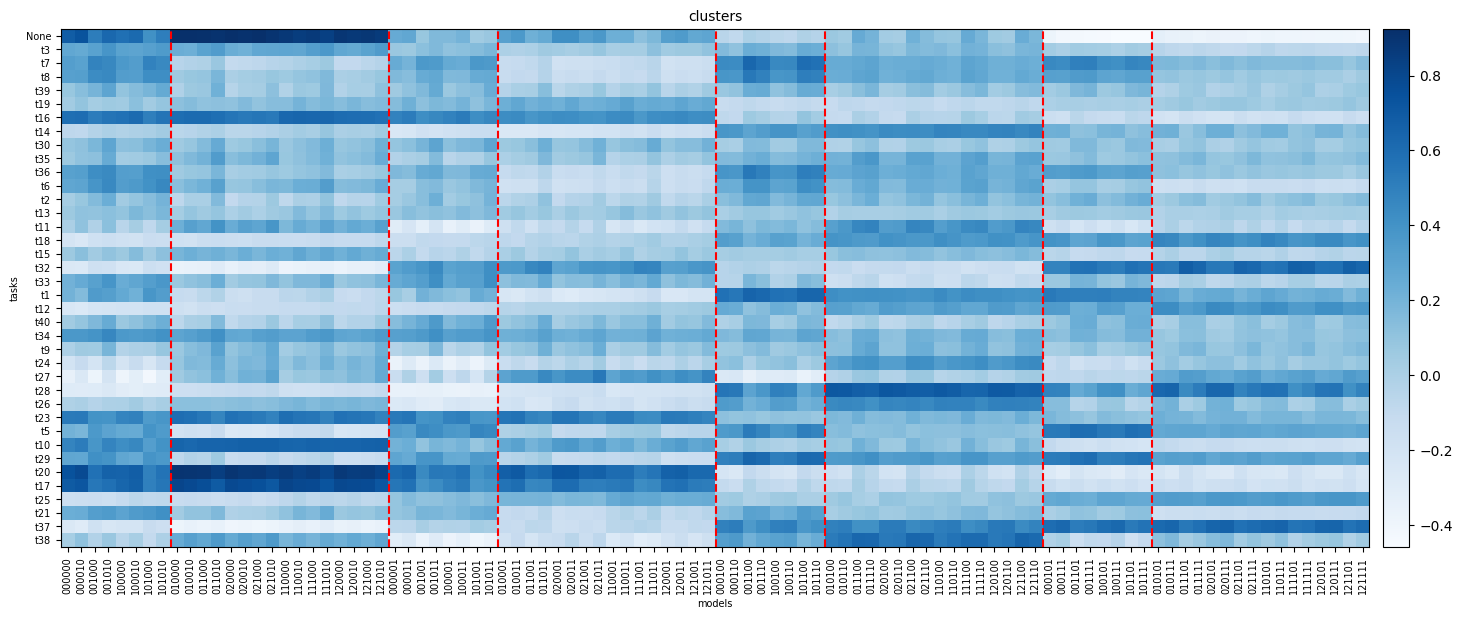

In [22]:
fig, ax = plt.subplots(figsize=(15,6))

cax = ax.imshow(matrix_models_tasks, cmap="Blues")
ax.set_xticks(np.linspace(0, len(models_names)-1, len(models_names)))
ax.set_xticklabels(models_names, rotation=90, fontsize=7)

ax.set_yticks(range(len(task_keys)))
ax.set_yticklabels(task_keys, fontsize=7)

ax.set_xlabel('models', fontsize=7)
ax.set_ylabel('tasks', fontsize=7)

cum_sum = 0
for size in cluster_sizes[:-1]:
    cum_sum += size 
    ax.axvline(x=cum_sum-0.45, color='red', linestyle='--', ymin=0, ymax=1)

cbar = fig.colorbar(cax, pad=0.01, fraction=0.05 )  # Colorbar associated with the matrix
cbar.set_label('',fontsize=7)
plt.title('clusters', fontsize=10)
plt.tight_layout()
plt.savefig('/home/juan/Research/Artigos escritos/Embedding Process Mining Models/figures/similarity_matrix_models_vs_tasks.png')
plt.show()

pdc2023_000000.pnml


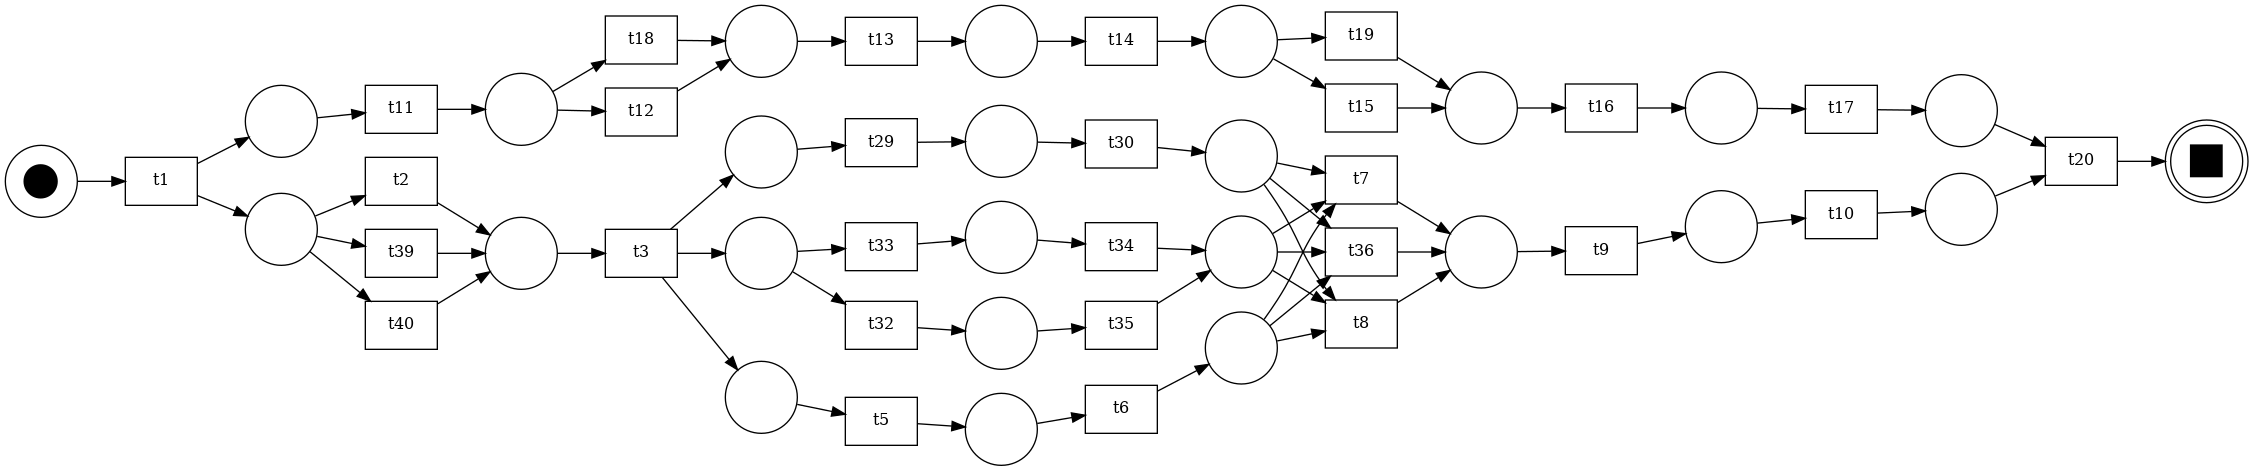

pdc2023_000010.pnml


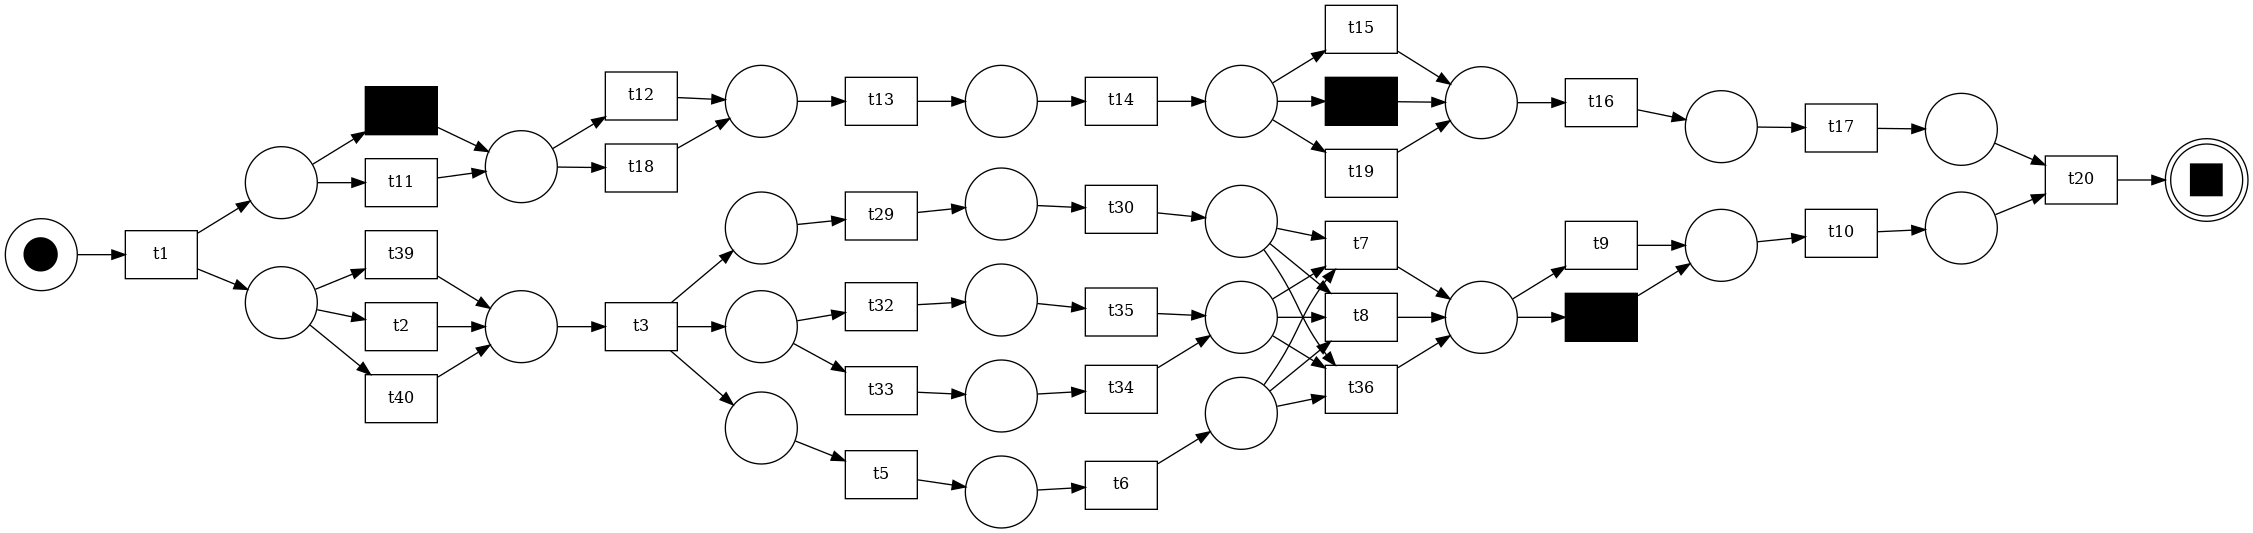

pdc2023_001000.pnml


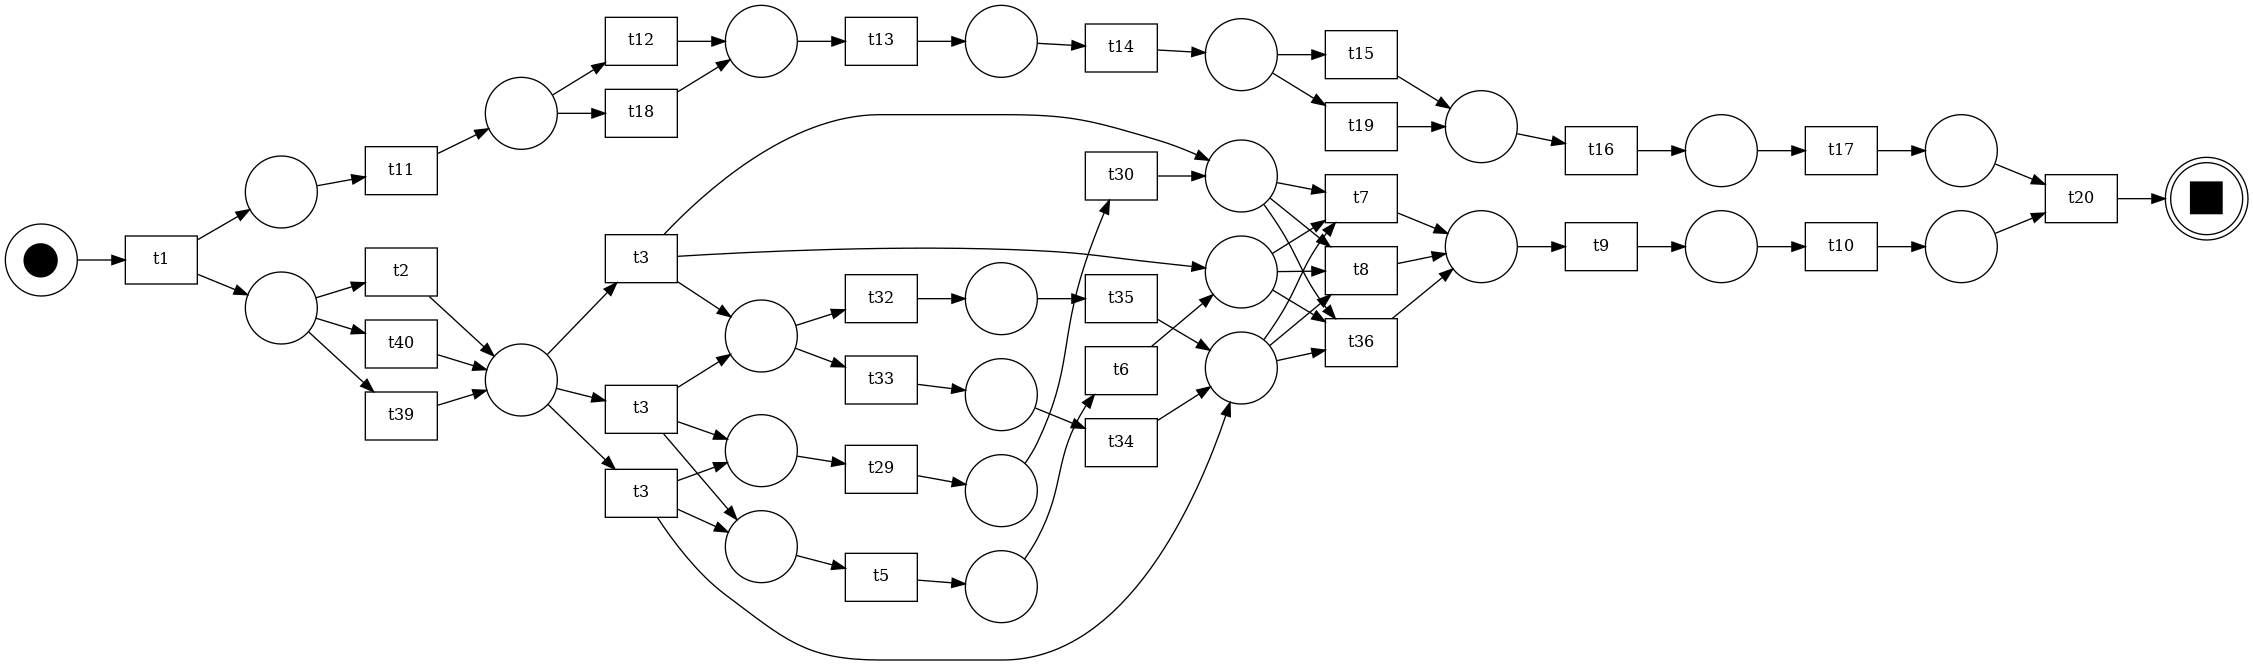

pdc2023_001010.pnml


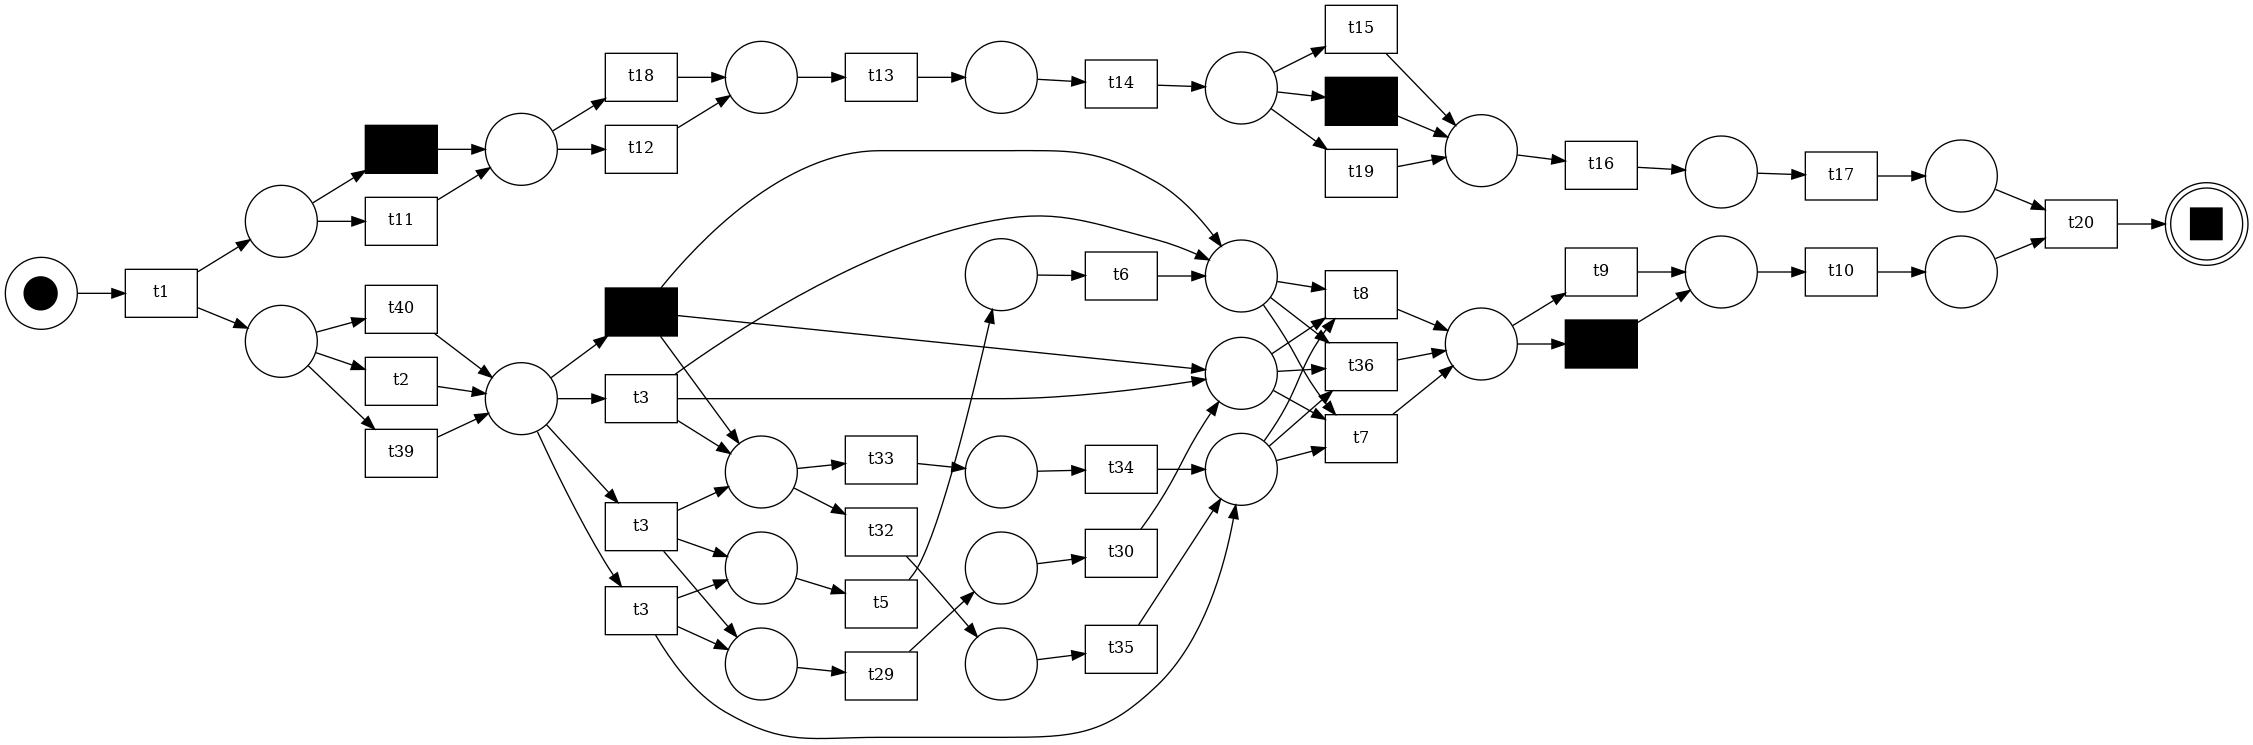

pdc2023_100000.pnml


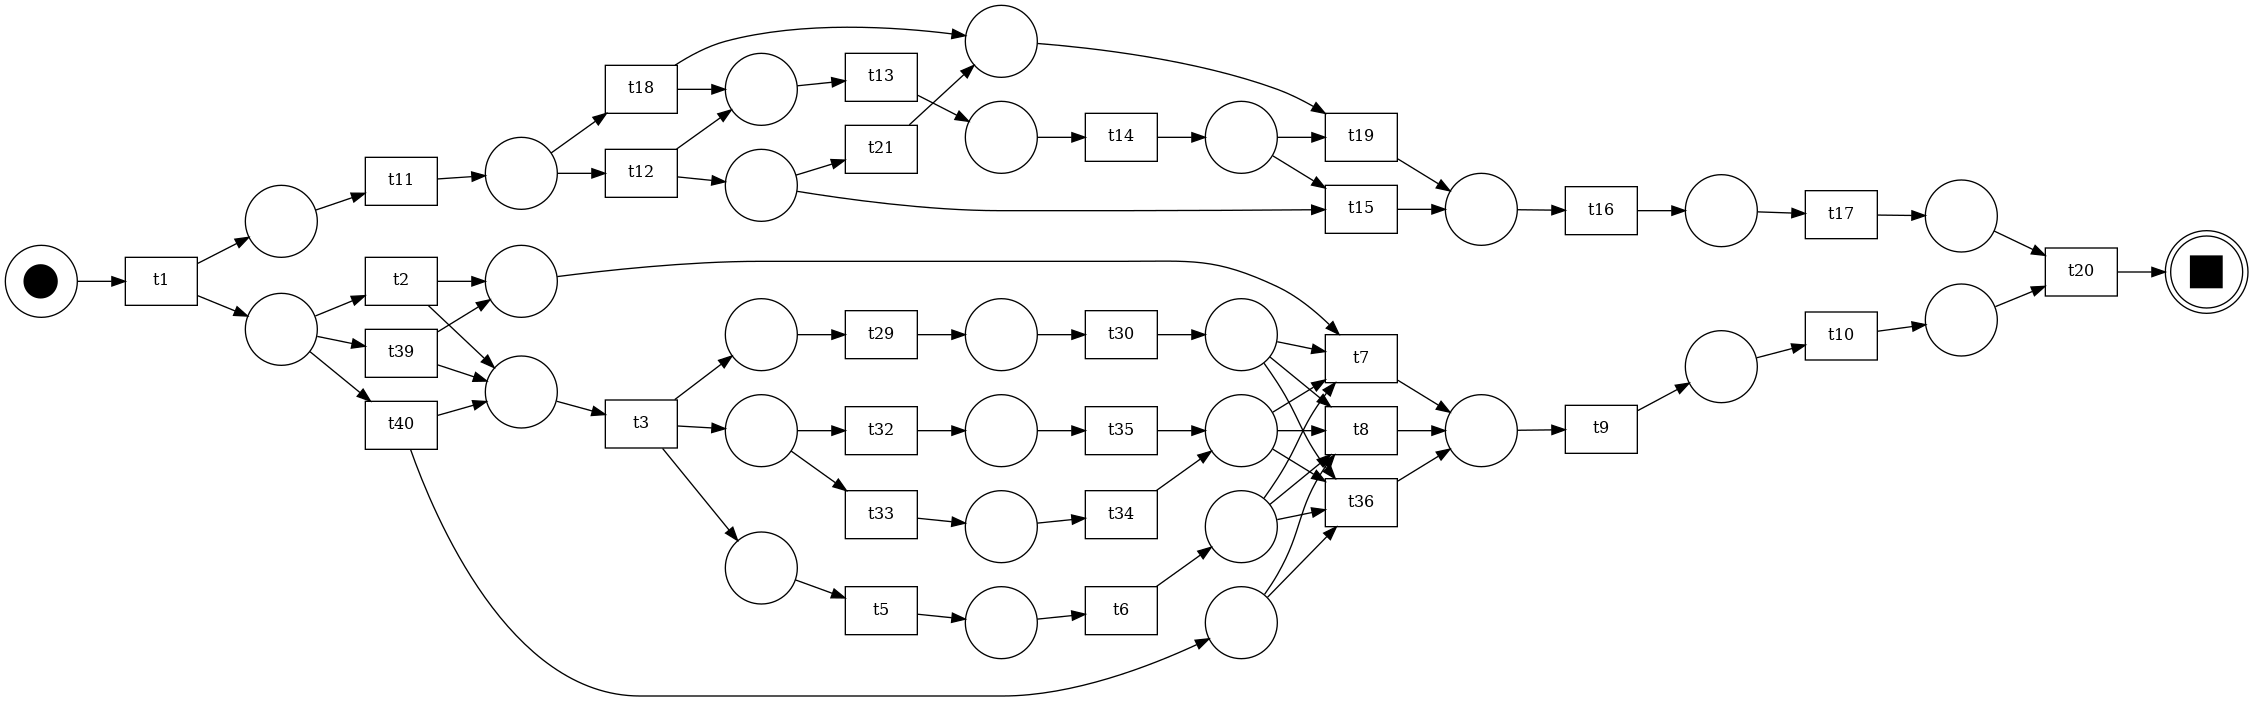

pdc2023_100010.pnml


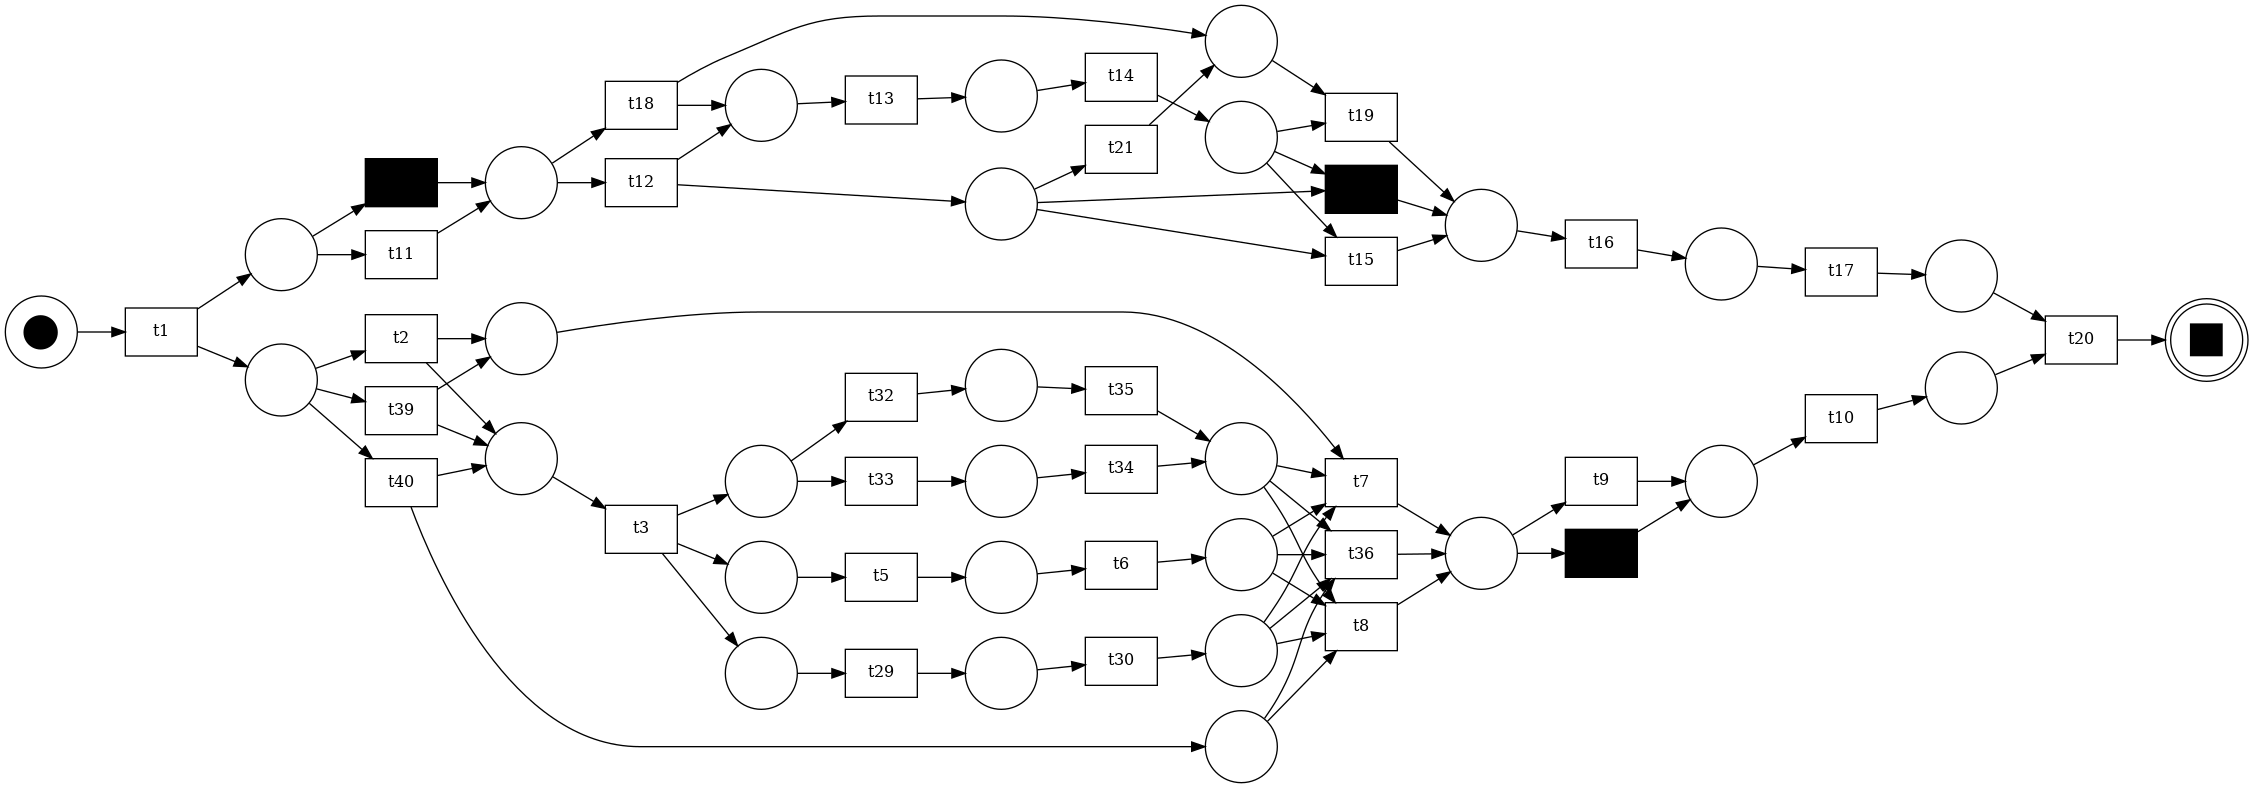

pdc2023_101000.pnml


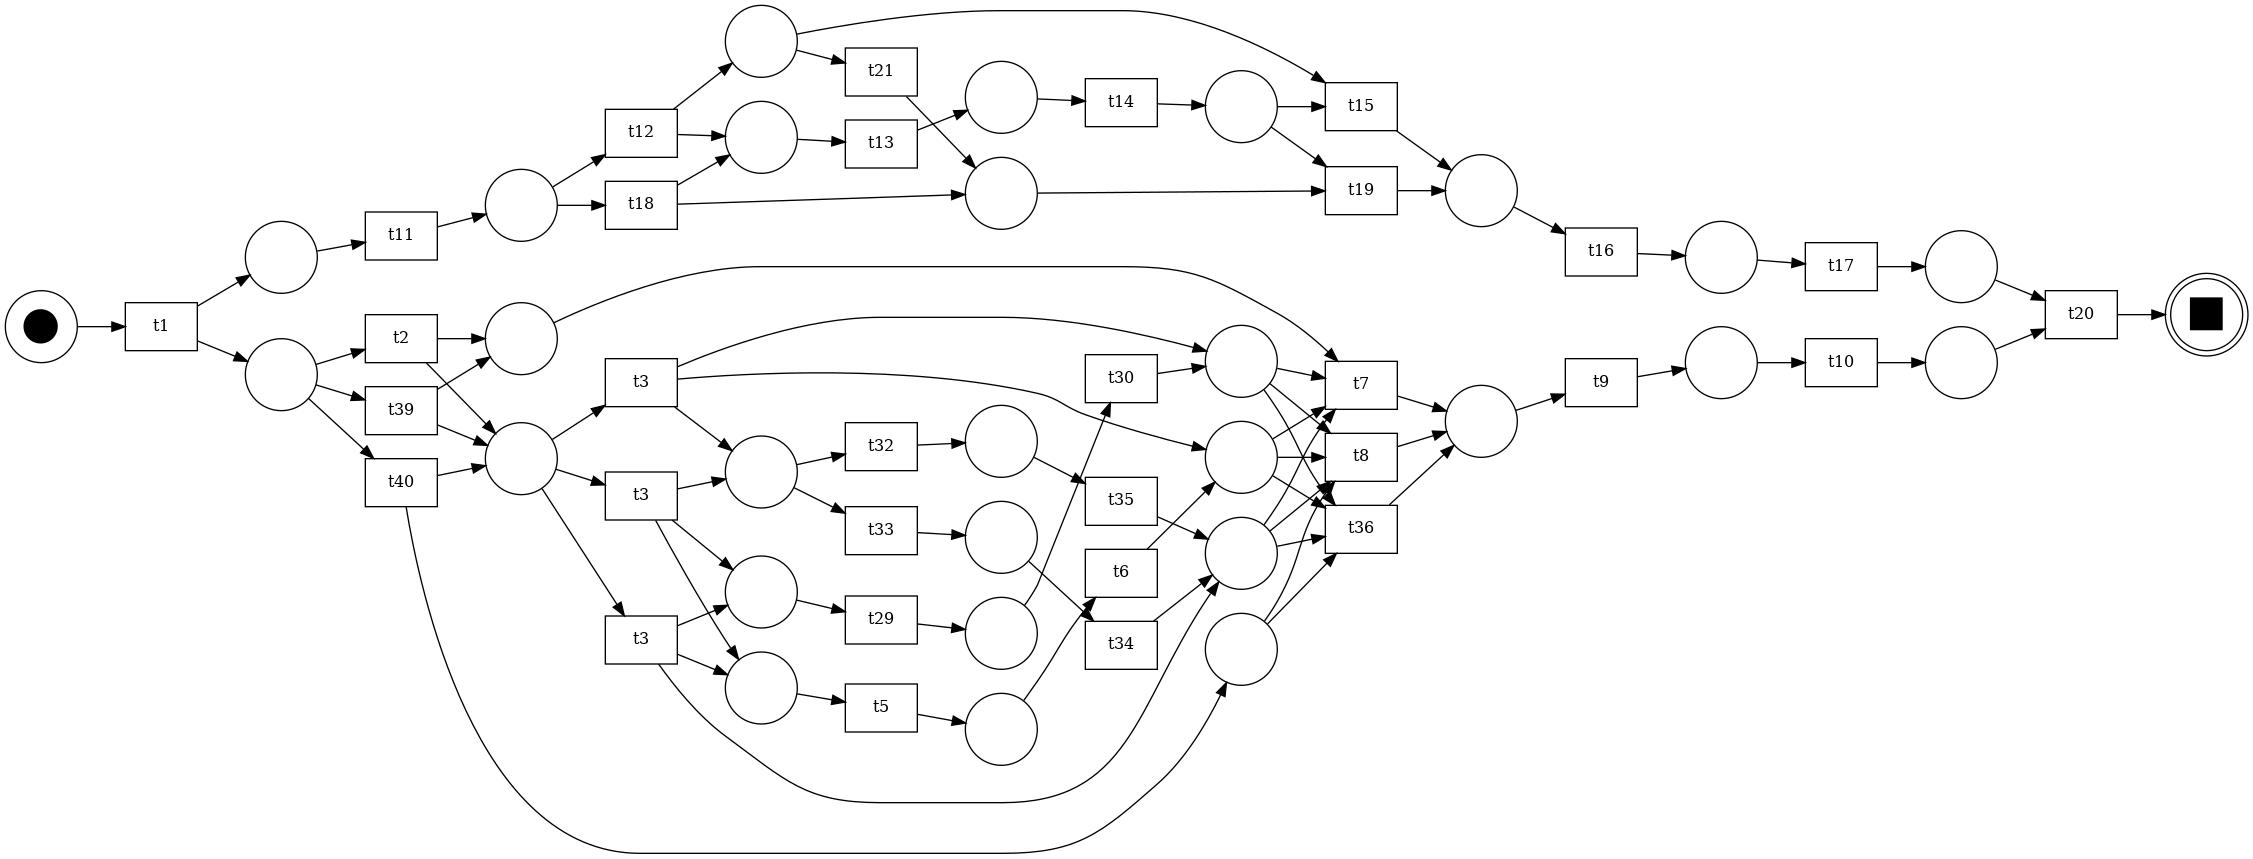

pdc2023_101010.pnml


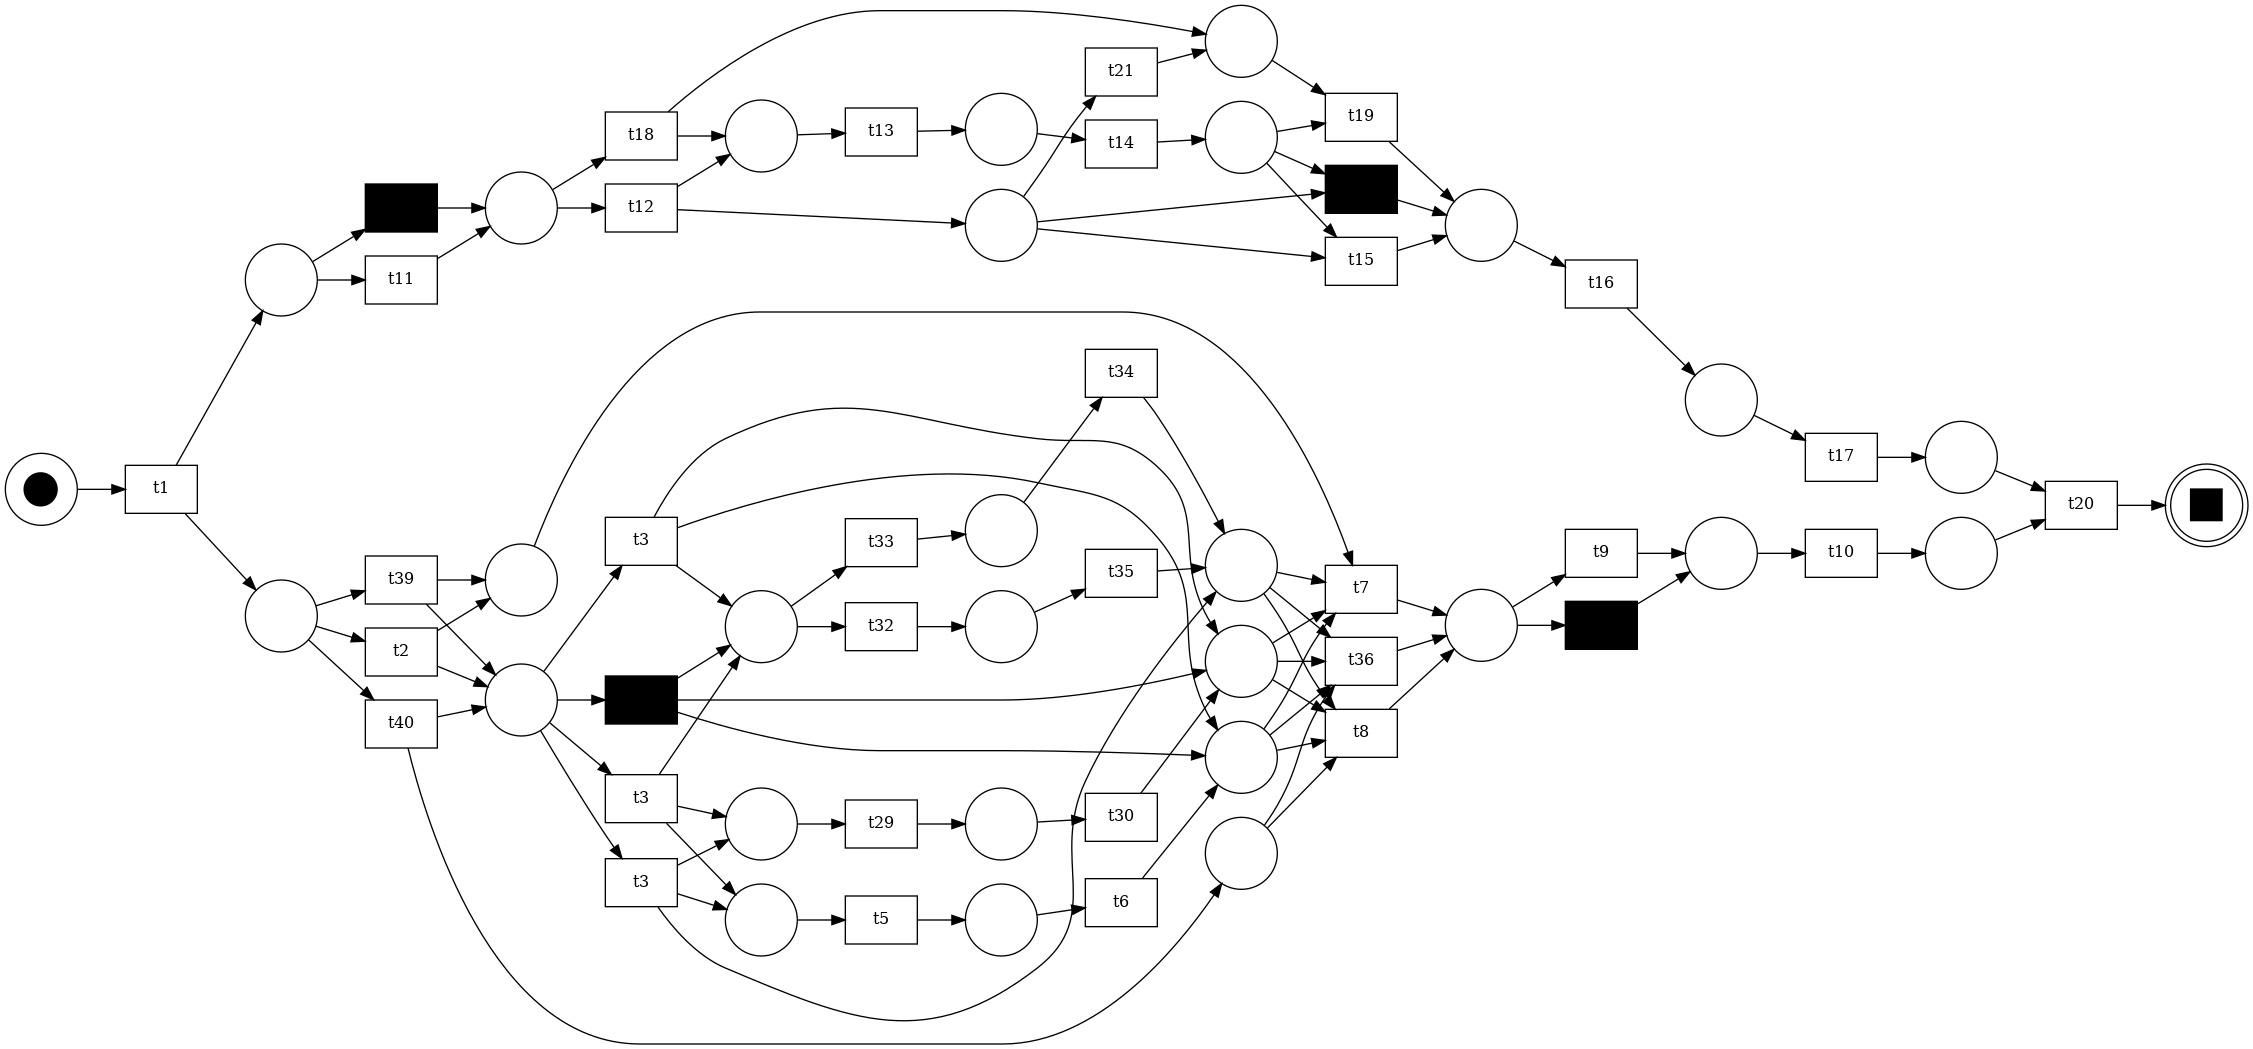

In [24]:
# showing the fisrt four cluster members and relataed tasks
for member in clusters_members['0']:
    print(member)
    net, im, fm = pm4py.read_pnml(os.path.join('../Dataset/Models/', member))
    pm4py.view_petri_net(net, im, fm)